# Time Series Analysis

## Workflow

1. Data Cleaning, EDA and Transformations <br/>
    * Simple Rolling Statistics and Plots
    * Correlation, Scatterplots, Histograms for multivariate time series
    * Stationarity (and transformations to induce it)
    * ACF & PACF Plots
        * Scatter plots and correlation between lags
    * Time series decomposition
        * Trend vs Seasonal Strength
2. Model Time Series<br/>
    * Naive Approaches
    * Linear Regression
    * Exponential Smoothing
    * AR, MA
    * ARMA, ARIMA, SARIMA, SARIMAX
    * ARCH, GARCH
    * Prophet
    * VAR
    * Neural Networks
    * Bootstrapping and bagging
3. Evaluate model
    * Residual diagnostics
    * RMSE, MAE, MAPE, MASE
    * R^2, AIC, BIC, CV
4. Improvements to Model
    * Feature selection
    * Time series cross validation
    * Hyper Parameter Tuning

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Analayse Time Series Data

In [2]:
spy_df = yf.download('SPY', datetime(2020,1,1), datetime(2023,7,10))

[*********************100%***********************]  1 of 1 completed


In [3]:
display(spy_df.head())
print(spy_df.shape)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,320.529999,322.130005,320.149994,321.859985,304.527771,57077300
2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375702,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048187,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211884,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350861,40496400


(885, 6)


### Visualization and Simple Statistics

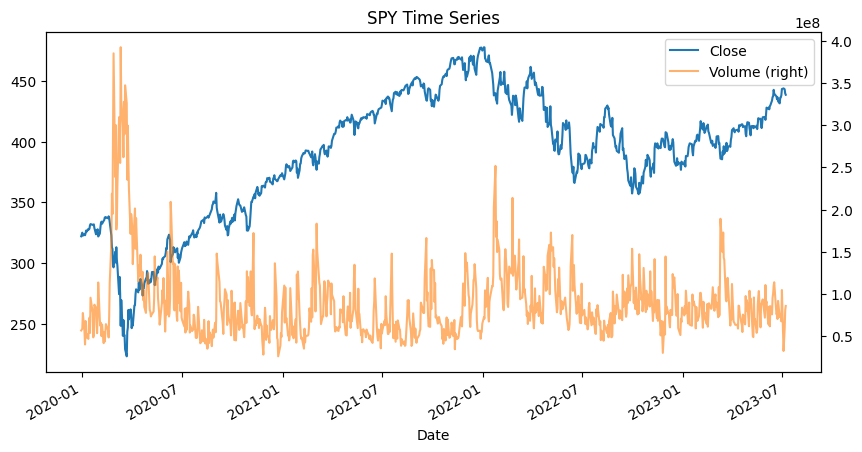

In [37]:
f, ax = plt.subplots(figsize=(10,5))
spy_df.plot(y='Close', use_index=True, label='Close', ax=ax)
spy_df.plot(y='Volume', use_index=True, secondary_y=True, label='Volume', alpha=0.6, ax=ax)
ax.set_title('SPY Time Series')
plt.show();

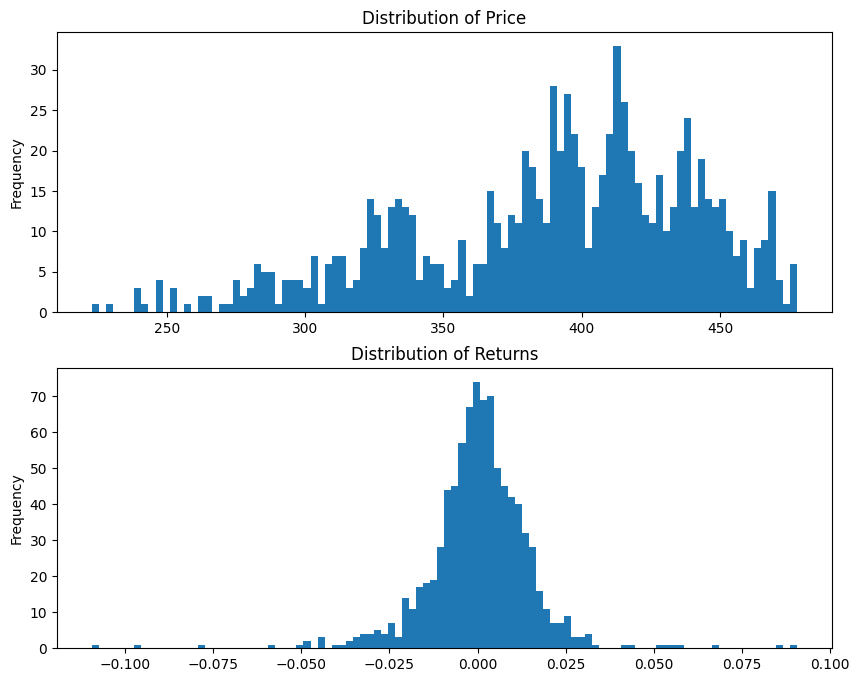

In [36]:
f, ax = plt.subplots(2,1, figsize=(10,8))
spy_df.Close.plot.hist(bins=100, title='Distribution of Price', ax=ax[0])
spy_df.Close.pct_change()[1:].plot.hist(bins=100,title='Distribution of Returns', ax=ax[1])
plt.show();

In [6]:
window = 20
ma20 = spy_df['Close'].rolling(window).mean()
std20 = spy_df['Close'].rolling(window).std()
skew20 = spy_df['Close'].rolling(window).skew()
kurt20 = spy_df['Close'].rolling(window).kurt()

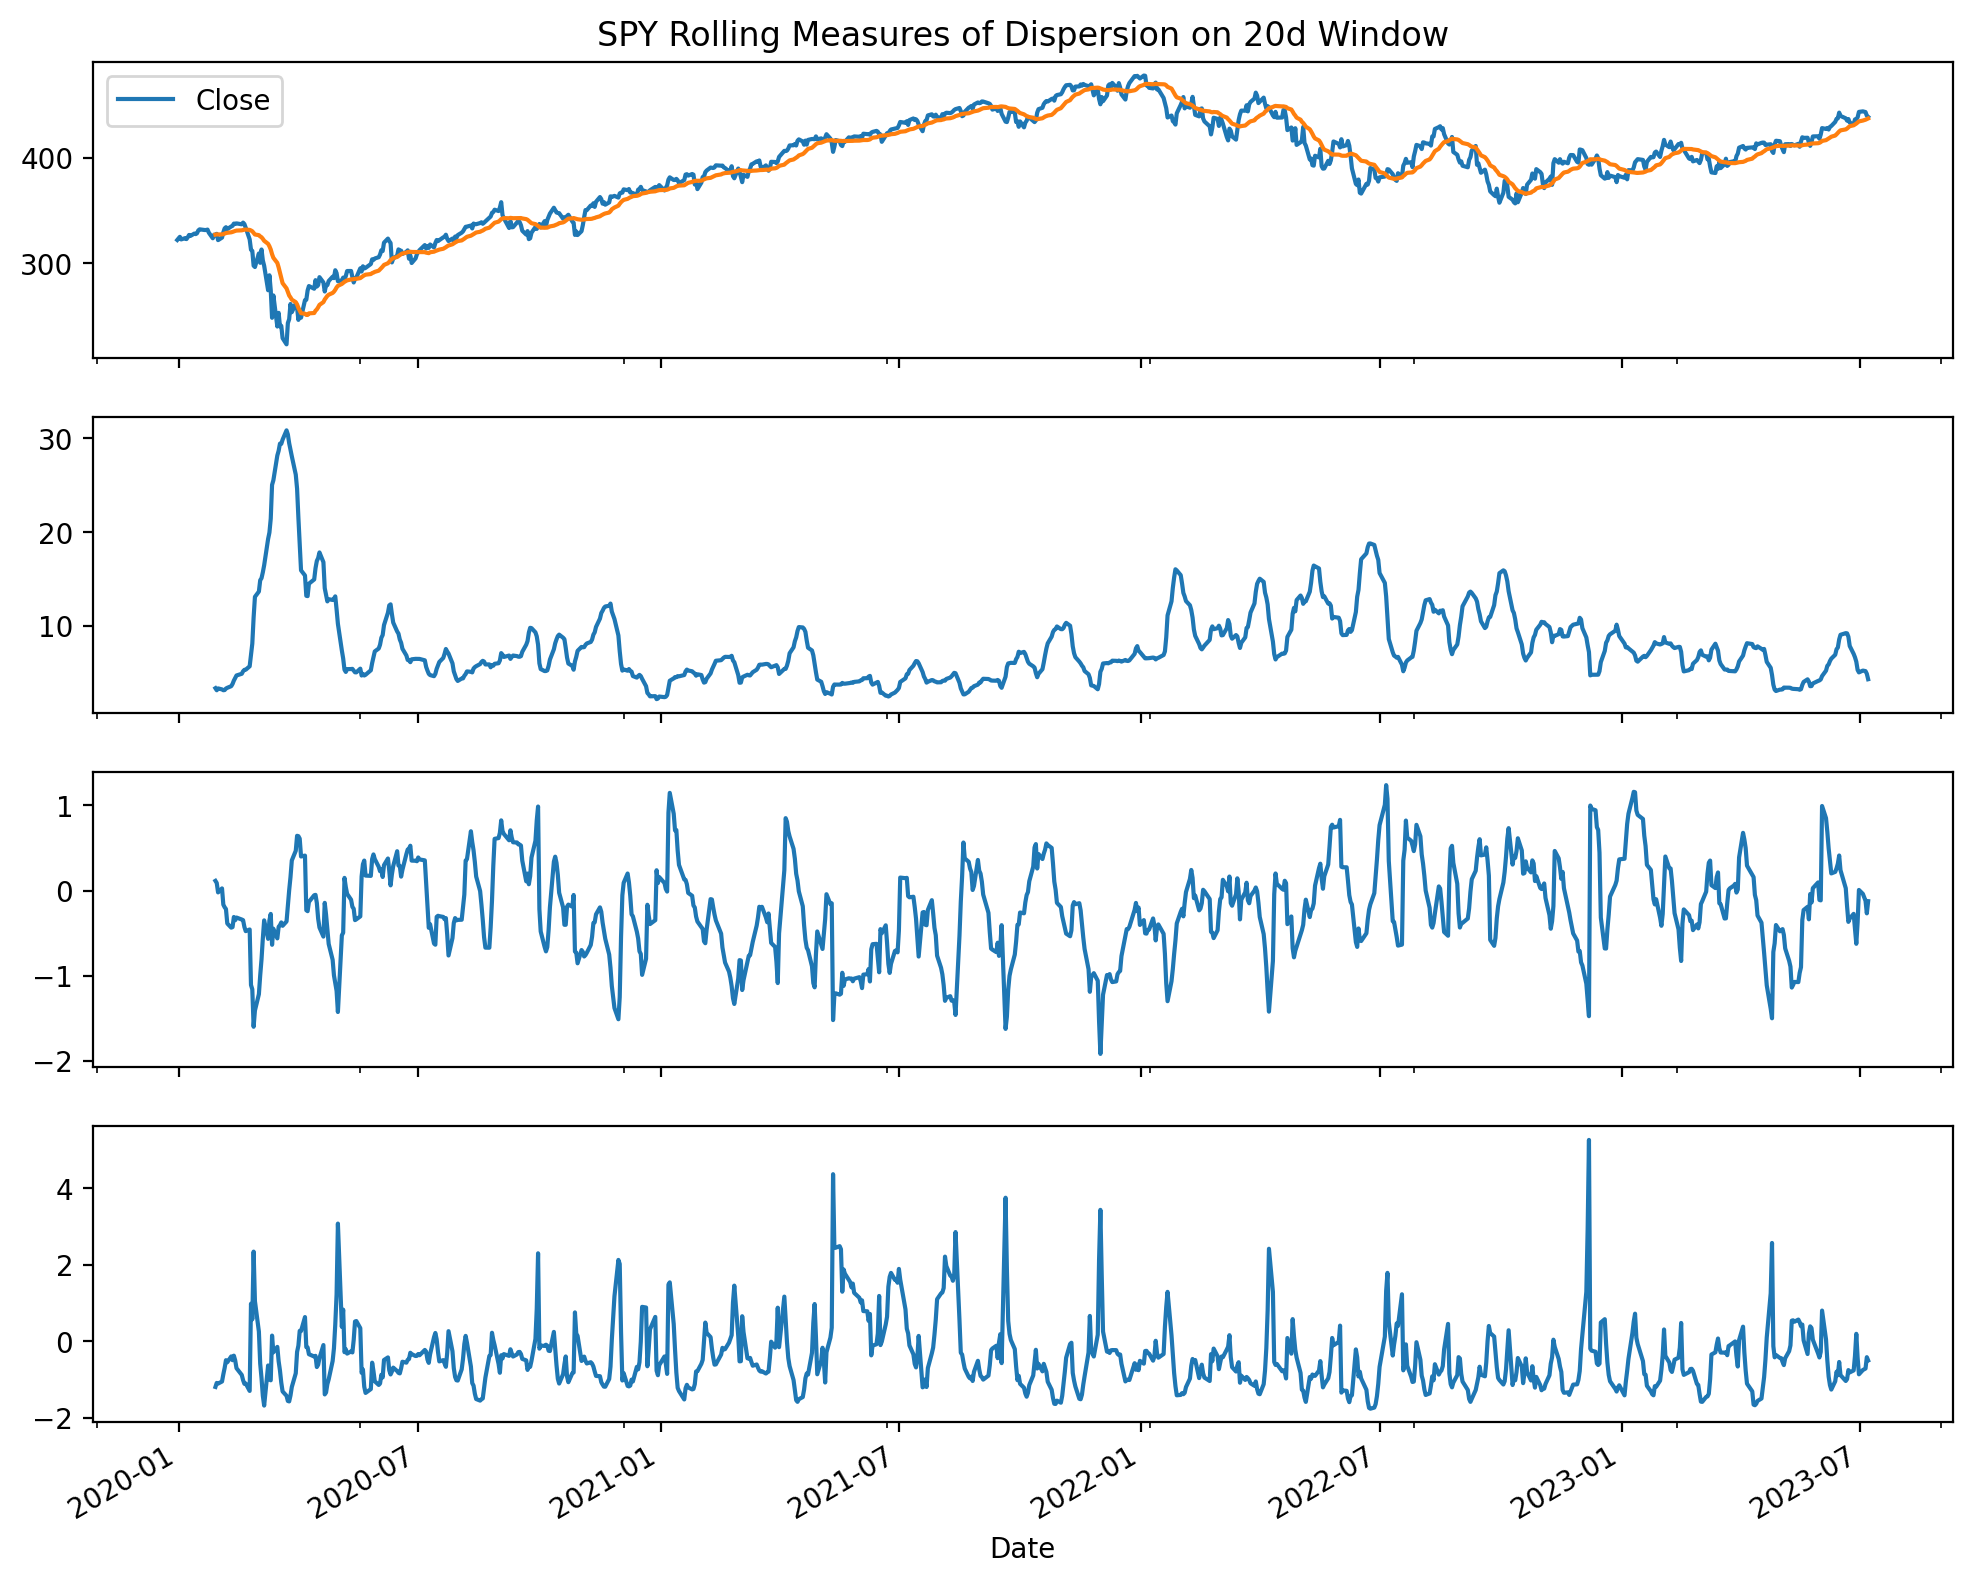

In [7]:
f, ax = plt.subplots(4,1, figsize=(12,10), dpi=200, sharex=True)
spy_df.plot(y='Close', use_index=True, ax=ax[0], label='Close', title='SPY Rolling Measures of Dispersion on 20d Window')
ma20.plot(ax=ax[0], label='mean')
std20.plot(ax=ax[1], label='std')
skew20.plot(ax=ax[2], label='skew')
kurt20.plot(ax=ax[3], label='kurt')
plt.show();

### Stationarity Test

In [8]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("Stationary")
    else:
        print("Non-stationary")

In [9]:
check_stationarity(spy_df.Close)

ADF Statistic: -1.537406
p-value: 0.514933
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Non-stationary


From the above plots, it's no surpriose that our price time series is non-stationary.

Non stationarity of price distribution can cause lots of problem for ML models. We might want to take log returns which refer to the log of the diff in price between time t-1 and time t. They are more normally distributed than raw price data and are time additive. This allows us to run ML models without fear of spurious results.

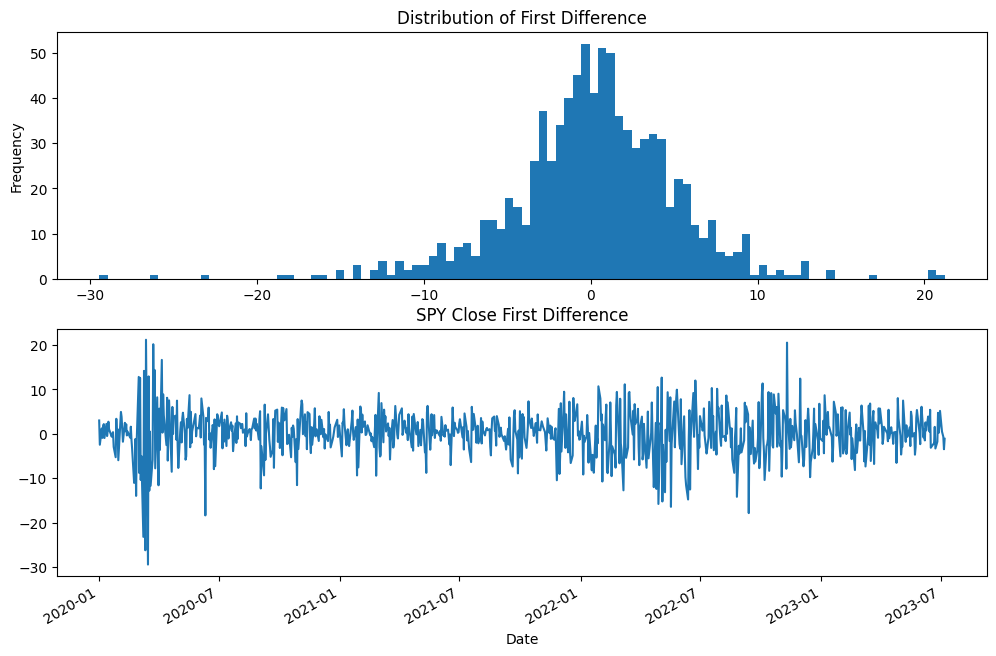

In [10]:
f, ax = plt.subplots(2,1, figsize=(12,8))
spy_df.Close.diff(1)[1:].plot.hist(bins=100,title='Distribution of First Difference', ax=ax[0])
spy_df.Close.diff(1)[1:].plot(title='SPY Close First Difference', ax=ax[1])
plt.show();

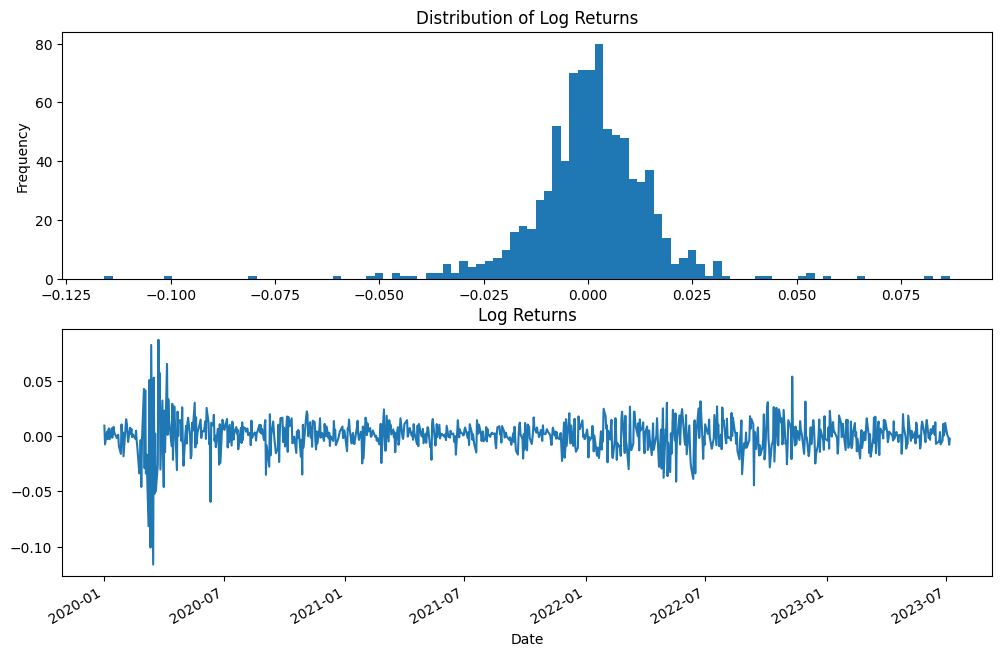

In [11]:
f, ax = plt.subplots(2,1, figsize=(12,8))
spy_df.Close.apply(np.log).diff(1)[1:].plot.hist(bins=100, title='Distribution of Log Returns', ax=ax[0])
spy_df.Close.apply(np.log).diff(1)[1:].plot(title='Log Returns', ax=ax[1])
plt.show();

In [12]:
check_stationarity(spy_df.Close.apply(np.log).diff(1)[1:])

ADF Statistic: -8.740519
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Stationary


In [13]:
check_stationarity(spy_df.Close.diff(1)[1:])

ADF Statistic: -9.076640
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Stationary


We will simply use first difference to build our model

In [14]:
spy_df['first_diff'] = spy_df.Close.diff(1)

### ACF, PACF Plots

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [21]:
def tsplot(y, lags=None, figsize=(12, 7)):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywmle')
    plt.tight_layout()

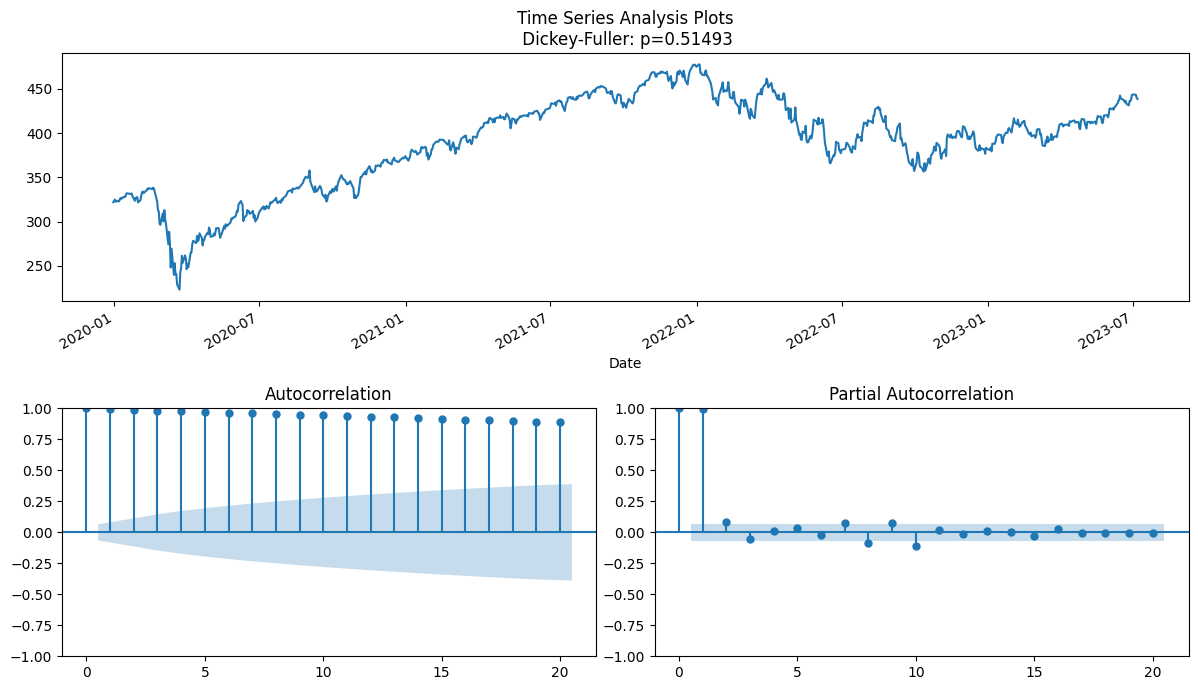

In [39]:
tsplot(spy_df.Close, 20)

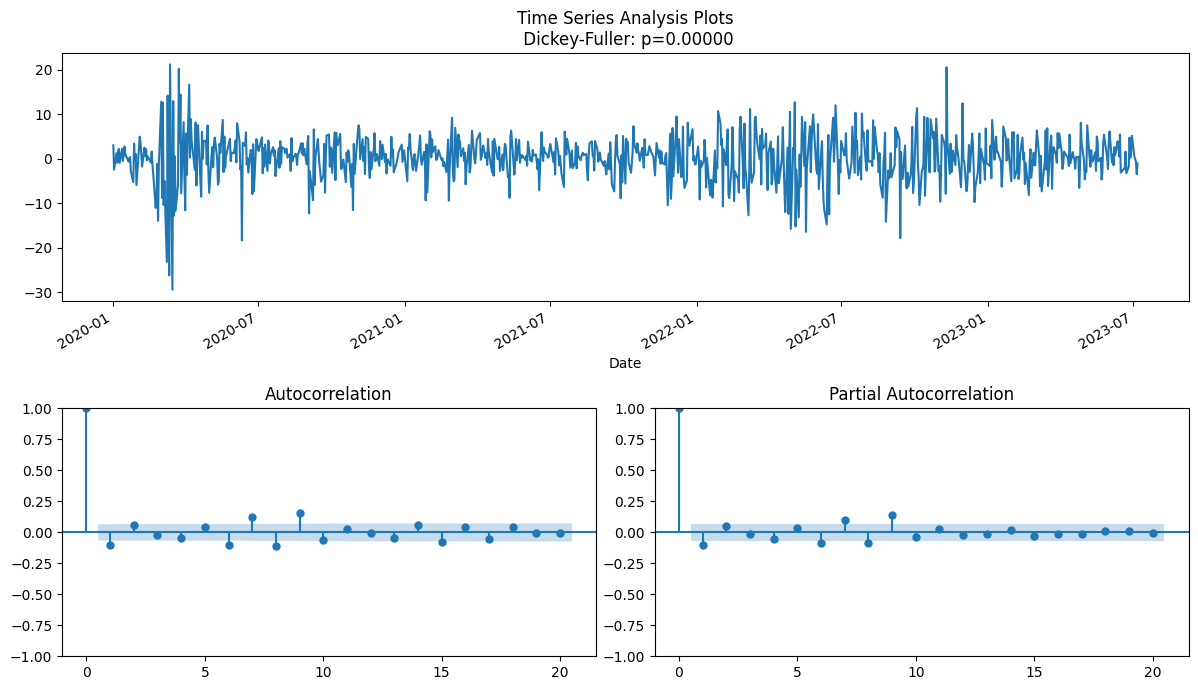

In [38]:
tsplot(spy_df.first_diff[1:], 20)

### Time Series Decomposition

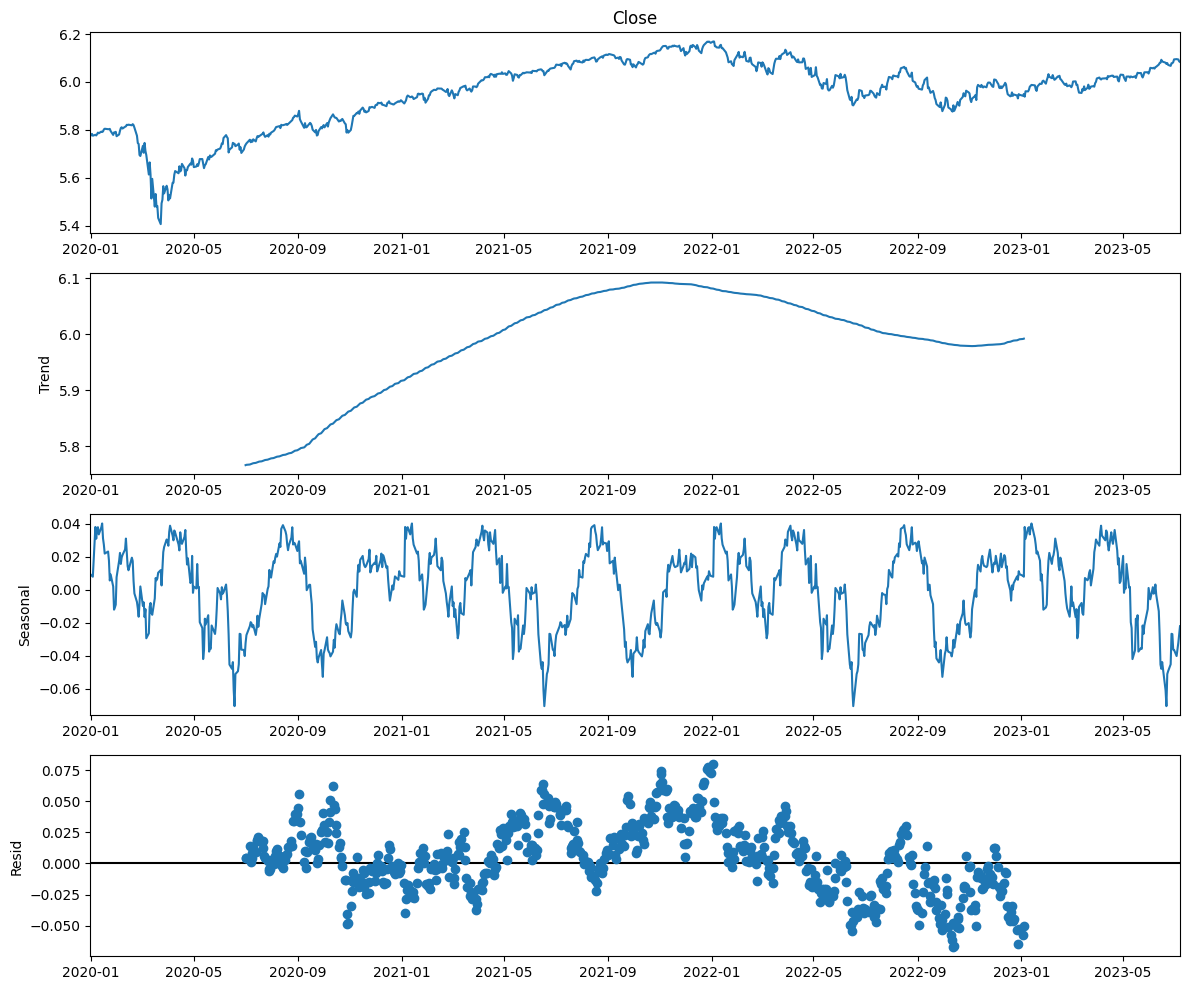

In [24]:
res = sm.tsa.seasonal_decompose(spy_df.Close.apply(np.log), model='additive', period=252)
resplot = res.plot()

In [25]:
spy_seasonality = res.seasonal[(res.seasonal.index >= '2021-09-01') & (res.seasonal.index <= '2022-01-01')]
ma20d = spy_seasonality.rolling(window=20).mean()

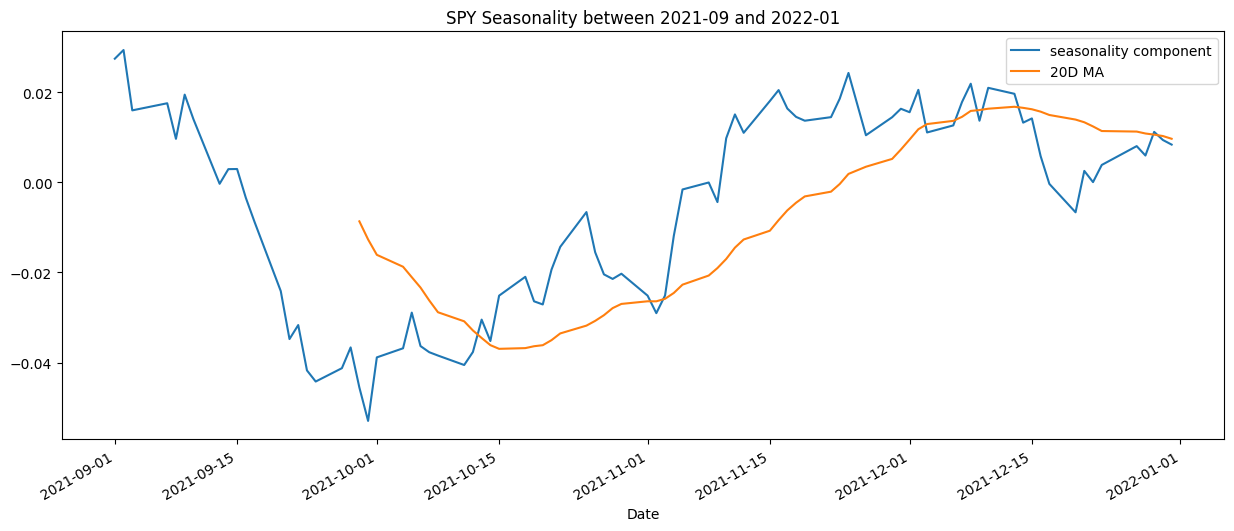

In [26]:
f, ax = plt.subplots(figsize=(15,6))
spy_seasonality.plot(ax=ax, label='seasonality component')
ma20d.plot(ax=ax, label='20D MA')
ax.set_title('SPY Seasonality between 2021-09 and 2022-01')
plt.legend();
plt.show();

In [27]:
spy_df['log_close'] = spy_df.Close.apply(np.log)

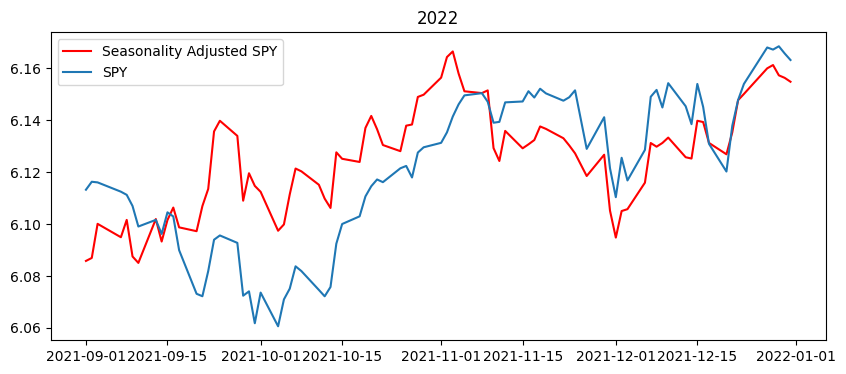

In [28]:
f, ax = plt.subplots(figsize=(10,4))
ax.plot(spy_df.log_close[(spy_df.index >= '2021-09-01') & (spy_df.index <= '2022-01-01')]-spy_seasonality,color='red',label='Seasonality Adjusted SPY');
ax.plot(spy_df.log_close[(spy_df.index >= '2021-09-01') & (spy_df.index <= '2022-01-01')],label='SPY')
ax.set_title('2022')
plt.legend()
plt.show();

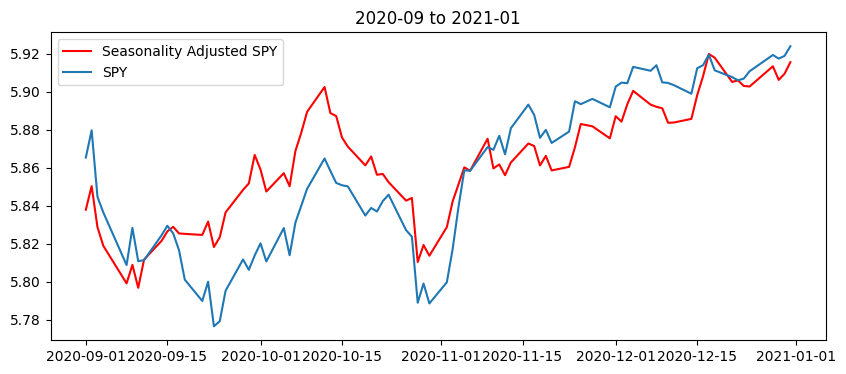

In [29]:
f, ax = plt.subplots(figsize=(10,4))
ax.plot(spy_df.log_close[(spy_df.index >= '2020-09-01') & (spy_df.index <= '2021-01-01')]-res.seasonal[(res.seasonal.index >= '2020-09-01') & (res.seasonal.index <= '2021-01-01')],color='red',label='Seasonality Adjusted SPY');
ax.plot(spy_df.log_close[(spy_df.index >= '2020-09-01') & (spy_df.index <= '2021-01-01')],label='SPY')
ax.set_title('2020-09 to 2021-01')
plt.legend()
plt.show();

## Modelling

### Linear Regression

In [34]:
spy_df['lagged_close'] = spy_df.Close.shift(1)
spy_df['lagged_first_diff'] = spy_df.first_diff.shift(1)

In [35]:
spy_df.head()

,Open,High,Low,Close,Adj Close,Volume,first_diff,log_close,lagged_close,lagged_first_diff
Date,,,,,,,,,,
2019-12-31,320.529999,322.130005,320.149994,321.859985,304.527771,57077300,NaN,5.774117,NaN,NaN
2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375702,59151200,3.010010,5.783425,321.859985,NaN
2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048187,77709700,-2.459991,5.775824,324.869995,3.010010
2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211884,55653900,1.230011,5.779632,322.410004,-2.459991
2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350861,40496400,-0.910004,5.776816,323.640015,1.230011


### AR, MA, ARIMA, SARIMA

### VAR